# Executive Summary

In this project, I built models for predicting the departure delay time of a flight based on features of the flight (time, carrier, airport, etc.) and the weather at the departure location on the day of the flight (temperature and precipitation).

I started by ingesting and cleaning the flight data (~500k domestic flights for Nov. 2013), and also scraped daily weather data from the Weather Underground for each airport. I then massaged the data to create new features (flight volume, dates, etc.), and joined the flight and weather data together. I also investigated the distribution of the target variable (departure delay time), which turned out to be very skewed.

I then built a supervised learning model using a machine learning pipeline --- written in Object-Oriented Python --- that could incorporate any arbitrary regression model: linear regression, random forest, etc. None of the models I investigated predicted the set of *test* data well. A model built using only weather features explained virtually zero variance in the data, perhaps indicating that weather is an unimportant feature.

Apart from its poor performance, the conventional ML model is deficient for other reasons. First, it doesn't take the *hierarchical* nature of the problem into account. Second, the predictions don't naturally incorporate uncertainty. Therefore, I also built a proof-of-concept Bayesian hierarchical model using the pymc3 package. Although the results are preliminary and require more validation, they provide insight into the separate effects of airports and carriers, and they indicate that weather *is* an important feature: for some airports and carriers more than others.

# Some Notes on Reading/Using This Notebook

I use a variety of Python packages in the Anaconda suite (pandas, numpy, scipy, scikit-learn, etc.). I also use pymc3 to build the Bayesian model. I have shipped the conda environment (custora.yml) along with the IPython notebook to indicate which versions of the packages I used.

Some of the cells in the notebook take almost an hour to run (particularly for the Bayesian model). If a certain cell has this feature, it is indicated in bold text. I would suggest either running the entire notebook overnight or simply looking at the cell outputs instead of running those particular cells.

# Table of Contents

1. [Import Python Modules and Packages](#import)
1. [Data Ingestion and Cleaning](#data_ingestion)
    1. [Flight Data](#flight)
    1. [Weather Data](#weather)
1. [Initial Data Exploration](#initial)
1. [Analysis](#analysis)
    1. [Choice of Model](#model)
    1. [Approach 1: A Conventional Machine Learning Model](#ml)
    1. [Approach 2: A Hierarchical Bayesian Model](#bayes)
1. [Conclusions and Summary](#conclusions)

<a id='import'></a>

# Import Python Modules/Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
import scipy.optimize as spo
import scipy.stats as spstats
import sklearn.preprocessing as skpre
import sklearn.ensemble as skens
import sklearn.metrics as skmetrics
import sklearn.linear_model as sklinear
import pymc3 as pm
from __future__ import division
%matplotlib inline
pd.options.mode.chained_assignment = None # prevent spurious warnings for chained assignment

<a id='data_ingestion'></a>

# Data Ingestion, Cleaning, and Massaging

In this section, I perform the following steps:
1. Ingest the flight data from the csv file. Pandas's read_csv makes this step easy.
2. Remove artifacts from the import process (an extra, "bad" column).
3. Examine null values to determine their source/importance.
4. Massage the data to create new features.
5. Ingest the weather data from a csv file ('weather.csv'). This has been scraped from The Weather Underground; see accompanying notebook "Scrape_Weather.ipynb" for the code.
6. Join the weather data to the flight data using the airport and date as keys, to create one large dataframe with all of the relevant data.

**IMPORTANT NOTE**: Data files are assumed to be stored in a subdirectory called "data/"

In [2]:
SUBDIR = 'data/'

<a id='flight'></a>

## Flight Data

### Ingest

In [3]:
flightcsv = '1063608646_T_ONTIME_2013_11.csv'
dfflights = pd.read_csv(os.path.join(SUBDIR,flightcsv))

In [4]:
dfflights.columns

Index([u'YEAR', u'MONTH', u'DAY_OF_MONTH', u'CARRIER', u'FL_NUM', u'ORIGIN',
       u'ORIGIN_CITY_NAME', u'ORIGIN_STATE_NM', u'DEST', u'DEST_CITY_NAME',
       u'DEST_STATE_NM', u'DEP_TIME', u'DEP_DELAY', u'ARR_TIME', u'ARR_DELAY',
       u'CANCELLED', u'CANCELLATION_CODE', u'CARRIER_DELAY', u'WEATHER_DELAY',
       u'NAS_DELAY', u'SECURITY_DELAY', u'LATE_AIRCRAFT_DELAY',
       u'Unnamed: 22'],
      dtype='object')

### Clean

#### Bad Column
There is extraneous information at the right of the array, so I drop it.

In [4]:
print 'Bad column: "{0}"'.format(dfflights.columns[-1])
dfflights.drop(dfflights.columns[-1], axis=1, inplace=True)

Bad column: "Unnamed: 22"


#### Examining Null Values

The following table shows the number of null entries in each column.

In [5]:
nullcount = pd.isnull(dfflights).sum(axis=0)
for col, count in zip(dfflights.columns,nullcount):
    if count > 0:
        print col, count

DEP_TIME 4876
DEP_DELAY 4876
ARR_TIME 5331
ARR_DELAY 5937
CANCELLATION_CODE 498214
CARRIER_DELAY 425944
WEATHER_DELAY 425944
NAS_DELAY 425944
SECURITY_DELAY 425944
LATE_AIRCRAFT_DELAY 425944


##### Departure and Arrival Times and Delays

All of the null values for departure time/delay are associated with cancelled flights. However, this is not true for null values for arrival time/delay. Since I'm interested only in the departure delays, I don't need to deal with deleting entries and/or imputing values for the latter columns.

In [6]:
def print_possibly_bad_flights(dfflights,colname):
    """For a specified column, prints number of null entries for flights that *weren't* cancelled"""
    flight_is_cancelled = dfflights['CANCELLED'] == 1
    col_null_idx = pd.isnull(dfflights[colname])
    strange_flight_idx = col_null_idx & ~flight_is_cancelled
    print 'There are {0} flights with null {1} that weren\'t cancelled'.format(strange_flight_idx.sum(),colname)

for colname in ['DEP_TIME','DEP_DELAY','ARR_TIME','ARR_DELAY']:
    print_possibly_bad_flights(dfflights,colname)

There are 0 flights with null DEP_TIME that weren't cancelled
There are 0 flights with null DEP_DELAY that weren't cancelled
There are 249 flights with null ARR_TIME that weren't cancelled
There are 855 flights with null ARR_DELAY that weren't cancelled


##### Carrier, Weather, etc. Delays

All of the null "CARRIER_DELAY", "WEATHER_DELAY", etc. columns are associated with flights that arrived "on time". As seen below, "on time" means less than 15 minutes delay.

In [7]:
null_delay_idx = pd.isnull(dfflights['CARRIER_DELAY'])
max_delay_null = dfflights[null_delay_idx]['ARR_DELAY'].max()
min_delay_not_null = dfflights[~null_delay_idx]['ARR_DELAY'].min()
print 'Maximum arrival delay for flights with null \'[X]_DELAY\' columns: {0} minutes'.format(max_delay_null)
print 'Minimum arrival delay for flights with not null \'[X]_DELAY\' columns: {0} minutes'.format(min_delay_not_null)

Maximum arrival delay for flights with null '[X]_DELAY' columns: 14.0 minutes
Minimum arrival delay for flights with not null '[X]_DELAY' columns: 15.0 minutes


### Massaging Data/Creating New Features

#### Dates/Days of Week

I combine the year, month, and day of month to generate a date. This will be useful later on for joining the weather data.

In [8]:
dfdate = dfflights[['YEAR','MONTH','DAY_OF_MONTH']]
dfdate = dfdate.rename(columns = {'DAY_OF_MONTH':'DAY'})
date = pd.to_datetime(dfdate)
dfflights['DATE'] = date

Clearly, all of the flights in our dataset took place in November 2013

In [9]:
datefmt = '%b %d, %Y'
print 'Earliest date: {}'.format(dfflights['DATE'].min().strftime(datefmt))
print 'Latest date: {}'.format(dfflights['DATE'].max().strftime(datefmt))

Earliest date: Nov 01, 2013
Latest date: Nov 30, 2013


#### Volume of Flights

The volume of flights at an airport on a particular date is a measure of how "busy" the airport is, so it may be an important feature

In [10]:
dfvolume = dfflights.groupby(['DATE','ORIGIN']).size().reset_index()
dfvolume.rename(columns={0: "VOLUME"},inplace=True)

<a id='weather'></a>

## Weather Data

See the accompanying notebook: Scrape_Weather.ipynb. There are roughly 300 unique locations (airports) for which we want to obtain the daily weather (for each day in Nov. 2013). I created a scraper to obtain this data from The Weather Underground (http://www.wunderground.com), which allows one to search for weather at an airport station. The data is saved in 'weather.csv'.

I extract two features for each day: the temperature and the precipitation.  Of course, more features (wind, humidity, etc.) could be important, but for a "first-pass" analysis, I think these two features are sufficient.

### Unique Airport Locations

In [11]:
unique_airports = np.unique(dfflights['ORIGIN'])
print 'There are {0} unique airports'.format(unique_airports.shape[0])
np.save(os.path.join(SUBDIR,'airports'),unique_airports)

There are 305 unique airports


### Load Weather Data (Already Scraped and Saved)

In [12]:
dfweather = pd.read_csv(os.path.join(SUBDIR,'weather.csv'),encoding='utf-8',index_col=0)

## All Data

To combine the tables, I first join the flight volume with the weather data. Then, I simply join to the flight data on airport and the day of the month.

In [13]:
dfweather['DAY'] = [pd.to_datetime(date).day for date in dfweather['Date']]

In [14]:
dfflights = pd.merge(dfflights, dfvolume,how='inner', on=['DATE','ORIGIN'])
dfall = pd.merge(dfflights, dfweather, how='left', left_on=['ORIGIN','DAY_OF_MONTH'], right_on=['Airport','DAY'])
dfall.drop(['Date','Airport'],axis=1,inplace=True)

<a id='initial'></a>

# Initial Data Exploration and Analysis

Here, I am interested in a few topics:
1. What is the distribution of the target variable (i.e., departure delay times)?
1. How should I treat outlier flights? And cancelled flights?
1. What are the salient features?
1. What are the distributions of the continuous features?
1. How skewed are the distributions for the categorical features: i.e., are there carriers or airports with very few flights? This will pose a challenge for traditional machine learning models.

## Distribution of Departure Delay Times

These are explored by looking at percentiles of the distribution and plotting histograms.

### Code for Plotting Histograms

In [15]:
def my_histogram(data,xlabel,ylabel='Count',nbins=50,percmin=0,percmax=100,normed=False,
                 facecolor='green',alpha=0.75,figsize=(8,6),fontsize1=21,fontsize2=18,ticksize=[8,2],
                 xlim=None):
    """Creates a pretty histogram. Can also truncate outliers using percmin, percmax"""
    fig = plt.figure(1,figsize)
    ax = fig.gca()
    datamin, datamax = np.percentile(data,percmin), np.percentile(data,percmax)
    bins = np.linspace(datamin,datamax,nbins)
    ax.hist(data,bins=bins,facecolor=facecolor,alpha=alpha,normed=normed)
    ax.set_xlabel(xlabel,fontsize=fontsize1)
    ax.set_ylabel(ylabel,fontsize=fontsize1)
    if xlim is not None:
        ax.set_xlim(xlim)
    ax.tick_params(axis='both',labelsize=fontsize2,width=ticksize[1],length=ticksize[0])
    return fig

### Delay Times Histogram

Plotting the histogram of delay times reveals that there are large outliers. Truncating the range to the 1st percentile - 99th percentile gives better results. The distribution is quite skewed to the right.

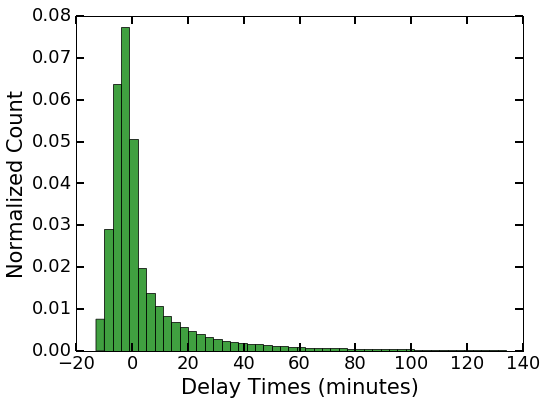

In [16]:
flight_is_cancelled = dfall['CANCELLED'] == 1
delaytimes = dfall[~flight_is_cancelled]['DEP_DELAY']
fig = my_histogram(delaytimes,xlabel='Delay Times (minutes)',ylabel='Normalized Count',
                   percmin=1,percmax=99,normed=True)

### Percentiles

As seen below, the difference between percentiles 0 (the min) and 0.5, and between percentiles 99.5 and 100  (the max) is huge.

In [17]:
for i in [0,0.5,1,99,99.5,100]:
    print 'Percentile {0} of the delay times is {1} minutes'.format(i,np.percentile(delaytimes,i))

Percentile 0 of the delay times is -81.0 minutes
Percentile 0.5 of the delay times is -15.0 minutes
Percentile 1 of the delay times is -13.0 minutes
Percentile 99 of the delay times is 134.0 minutes
Percentile 99.5 of the delay times is 180.0 minutes
Percentile 100 of the delay times is 1860.0 minutes


## Treating Outliers, Cancelled Flights vs. Delayed Flights

It's difficult to assign an appropriate delay time to a cancelled flight. Here, I will take the approach that the model should predict delay times, *conditioned* on the flight *not* being cancelled.

It is unlikely that any model will be able to predict extreme negative values for delay times. These values appear to be associated with very small airports, often in remote locations like Alaska (see below). So, I will take the approach of only trying to model the top 99.5% of the data.

I will also shift the delay times upward by 15.0 minutes to ensure all of the delay times are non-negative, and normalize the times so that the mean is roughly at 1. The resulting distribution appears roughly log-normal, although the peak is underestimated (see below).

### The 10 Flights with the Most Negative Delay Times

Most of these originate in remote states: Alaska, North Dakota, etc.

In [18]:
dfall[['ORIGIN','ORIGIN_STATE_NM','DEP_DELAY']].sort_values('DEP_DELAY').iloc[:10]

,ORIGIN,ORIGIN_STATE_NM,DEP_DELAY
458940,BRW,Alaska,-81.0
459957,PSG,Alaska,-73.0
257128,BWI,Maryland,-52.0
444240,TUS,Arizona,-50.0
488069,ISN,North Dakota,-48.0
464754,YAK,Alaska,-45.0
498776,ACV,California,-40.0
501712,RKS,Wyoming,-39.0
460202,WRG,Alaska,-39.0
221617,PIT,Pennsylvania,-38.0


### Remove Cancelled Flights and Really Early Flights

In [19]:
dmin = np.percentile(delaytimes,0.5)
dfdelayed = dfall[~(flight_is_cancelled | (dfflights['DEP_DELAY'] < dmin))]
dfdelayed.reset_index(drop=True,inplace=True);

### Transform the Target Variable (Min = 0; Mean = 1)

In [20]:
delaytimes = dfdelayed['DEP_DELAY'] - dmin
delaytimes = np.clip(delaytimes,0.0,np.inf)
dmean = delaytimes.mean()
dfdelayed['DEP_DELAY_INTER'] = delaytimes/dmean

### Plot a Histogram with a Log_Normal Fit

**This takes 20 seconds!**

The data appears to be roughly log-normal, although the peak is underestimated by the fit.

In [21]:
def histogram_with_fit(data,distribution,percmin=1,percmax=99):
    fig = my_histogram(data,xlabel='Normalized Delay Times',ylabel='Normalized Count',
                       percmin=percmin,percmax=percmax,normed=True)
    xvec = np.linspace(np.percentile(data,percmin),
                       np.percentile(data,percmax),
                       2000)
    params = distribution.fit(data)
    yvec = distribution.pdf(xvec,*params)
    ax = fig.gca()
    ax.plot(xvec,yvec,'r-')
    return fig

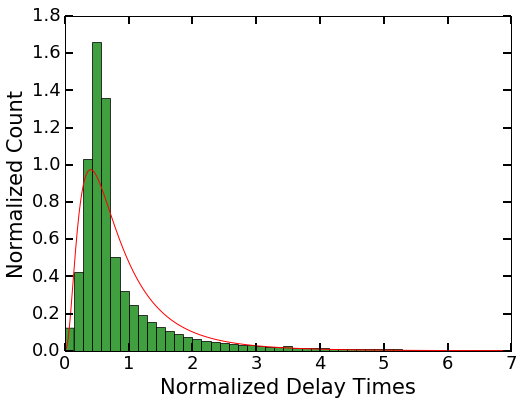

In [22]:
histogram_with_fit(data = dfdelayed['DEP_DELAY_INTER'],
                   distribution = spstats.lognorm,percmin=0);              

### Further Log-Transform the Data

The log-transform ensures that the prediction (made by exponentiating back) is always positive, which is what we want. The log-transformed data is not normal, but it is difficult to find a transformation that results in true normality.

In [23]:
eps = 0.001
dfdelayed['DEP_DELAY_TRANS'] = np.log(dfdelayed['DEP_DELAY_INTER'] + eps)

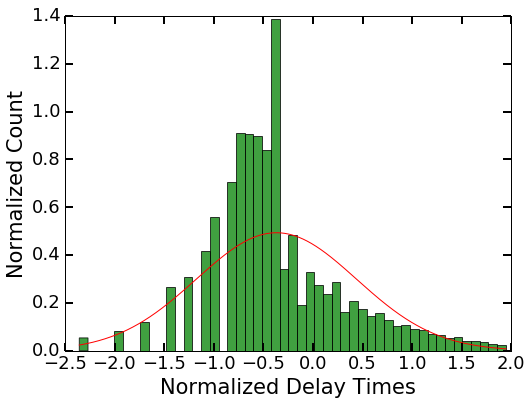

In [24]:
histogram_with_fit(data = dfdelayed['DEP_DELAY_TRANS'],
                   distribution = spstats.norm,percmin=1);    

In [25]:
spstats.mstats.normaltest(dfdelayed['DEP_DELAY_TRANS'])

NormaltestResult(statistic=115849.12324208749, pvalue=0.0)

## What are the Salient Features?

Salient:
1. Categorical Features:
    1. The carrier: Certain carriers may be better at departing on time than others
    1. The airport: Presumably, better managed airports should have lower average departure times
1. Non-Categorical Features:
    1. The volume of flights (on that day at that airport): This roughly measures how busy the airport is
    1. Departure time: Flights during peak hours may be more prone to delays
    1. The temperature (on that day at that airport): Weather may correlate with delays
    1. The precipitation (on that day at that airport): Weather may correlate with delays
    
Not salient:
1. The arrival delay is certainly correlated to the departure delay, but the causation runs in reverse. In other words, one can't use the arrival delay to predict the departure delay, since the arrival happens after the departure. Similiarly, all of the individual components of the arrival delay (carrier delay, weather delay, security delay, etc.) are not useful.

Possibly salient:
1. Unique flight id (i.e., the combination of the carrier and the flight number): Presumably, the same flights are consistently delayed over time. However, there are 18467 unique flight ids, and the data for many of them is extremely sparse (500000 entries/18467 unique ids = 25 flights, on average), which makes our models prone to high variance. So, in this investigation, I'll omit this feature.
1. The mean *past* delay for the unique flight id. We could build a model with only this feature, and it might perform well. However, it doesn't provide any insight into the effects of weather, carrier, airport, etc., since it already incorporates these features.

In [26]:
print 'There are {0} unique flight ids'.format(dfdelayed.groupby(['FL_NUM','CARRIER']).size().shape[0])

There are 18458 unique flight ids


## What are the Distributions for the Continuous Features?

There are a few outliers for temperature and precipitation (i.e., flights in cold weather and flights in heavy rain), but these don't appear to be associated with "bad" measurements.

#### Flight Volume

There don't appear to be any outliers in the flight volume distribution; some airports have only a few flights per day, while others have ~1000.

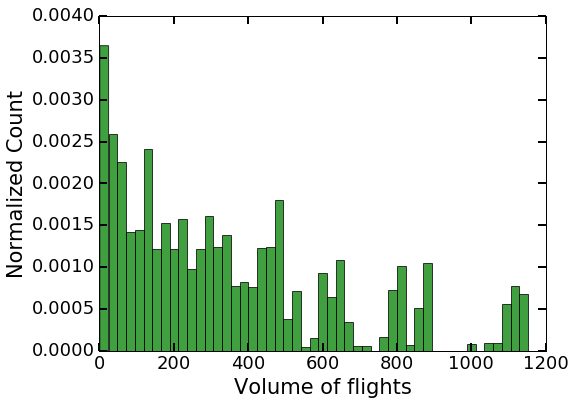

In [27]:
fig = my_histogram(dfdelayed['VOLUME'],xlabel='Volume of flights',ylabel='Normalized Count',
                   percmin=0,percmax=100,normed=True)

#### Departure Time

Flights appear to depart roughly evenly throughout the day between 6 am and 8 pm.

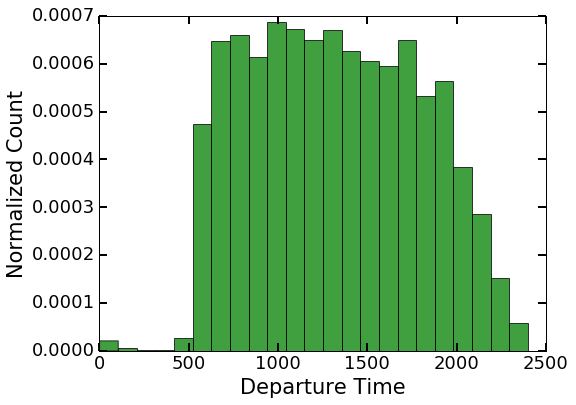

In [28]:
fig = my_histogram(dfdelayed['DEP_TIME'],xlabel='Departure Time',ylabel='Normalized Count',
                   percmin=0,percmax=100,nbins=24,normed=True)

#### Temperature

There are a few outliers for temperature (flights departing in extremely cold weather), but the distribution appears roughly bell shaped, with a peak at 50 F.

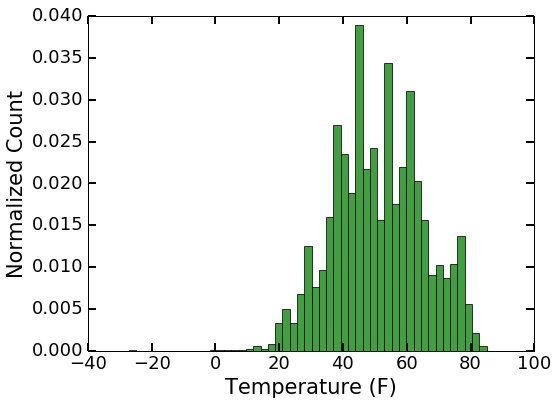

In [29]:
fig = my_histogram(dfdelayed['TEMP'],xlabel='Temperature (F)',ylabel='Normalized Count',
                   percmin=0,percmax=100,normed=True)

#### Precipitation

There are a few outliers for precipitation (flights departing in several inches of rain), but the vast majority depart in zero rain.

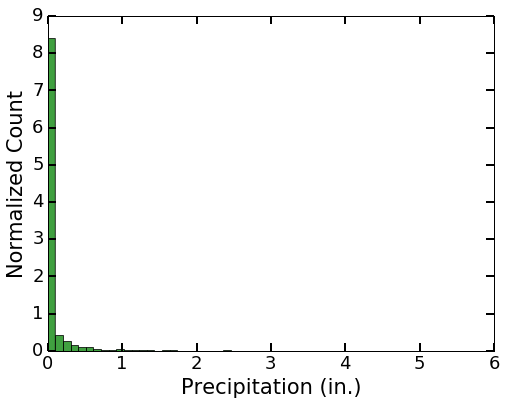

In [30]:
fig = my_histogram(dfdelayed['PRECIP'],xlabel='Precipitation (in.)',ylabel='Normalized Count',
                   percmin=0,percmax=100,normed=True)

## How Sparse is the Data when Grouped by Categorical Features?

The data grouped by carrier is not sparse, but the data grouped by airport is. Even for the smallest carrier, there are almost 5000 flights. However, for the smallest airports, there are only a few flights, while for the largest airports, there are >10000 flights. This fact will create problems for the conventional ML approach, discussed below.

### Carriers

In [31]:
print 'The smallest ten carriers, by number of flights:'
dfdelayed.groupby(['CARRIER']).size().sort_values()[:10]

The smallest ten carriers, by number of flights:


CARRIER
VX     4712
HA     5793
F9     6258
YV    11283
FL    11622
AS    11775
B6    19392
9E    22210
MQ    32523
US    33266
dtype: int64

In [32]:
print 'The smallest ten airports, by number of flights:'
dfdelayed.groupby(['ORIGIN']).size().sort_values()[:10]

The smallest ten airports, by number of flights:


ORIGIN
SPN     1
IYK     5
ADK     5
PPG     9
EGE    10
MTJ    19
DBQ    20
YAK    22
GUC    28
CDV    30
dtype: int64

<a id='analysis'></a>

# Analysis

<a id='model'></a>

## Choice of Model

We would like to build a regression model. I will assume that predictive accuracy is arguably not as important as interpretability: we want a sense of what features are important and why. In other words, we don't want a black box.

One important point is that all conventional ML models will suffer from the same types of problems:
1. We can pool all of the measurements, ignoring the effects of the categorical variables like airport and carrier. This is robust, but it doesn't provide insight into the effects of the categorical variables. For instance: which carriers are best and worst? Which airports are best and worst?
1. We can construct separate regressions for each combination of categorical variables. However, the data for certain combinations (e.g., at remote airports in Alaska), will be very sparse, as shown previously, and our predictions will exhibit high variance. Regularization/ensemble methods can help with this problem to some extent, but can't eliminate it entirely.

What we actually want is a hierarchical model, like a "random effects model" (in frequentist statistics) or a "hierarchical Bayesian model" (in Bayesian statistics). This is difficult to do in a traditional ML approach, however.

In spite of these problems, conventional ML models are relatively easy to run and analyze. I will go through the "standard" analysis using a random forest regression model. I chose the random forest for several reasons. First, the random forest can incorporate non-linear and feature interaction effects (which might be important). Second, the target variable doesn't need to be normally distributed. Third, it has the implementational advantage that no feature scaling is needed.

Its main weaknesses are a lack of interpretability (feature importance is only measured indirectly), and possibly poor performance/high variance on a data set with a large number of features (such as the one-hot encoded categorical features).

In the final section, I will show how a Bayesian approach can ameliorate some of these concerns.

<a id='ml'></a>

## ML Pipeline

Building an ML model for this data is relatively easy using scikit-learn.

There are a few steps of pre-processing:
1. One-hot encoding of the categorical features
1. Scaling the non-categorical features (not needed for random forest)
1. Separating the dataframe into a feature matrix (X) and a target variable (y)
1. Further splitting the data into a train and test set: we'll train the model on flights from Nov. 1 - Nov. 20, and use that to predict delay times for flights from Nov. 21 - Nov. 30. (Since the data has a temporal component, randomly shuffling would not make sense.)

Afterwards:
1. The model is trained on the training set.
1. The test and training set R^2 are evaluated to get a sense of the bias vs. variance.
1. The feature importances are analyzed.

Two notes on the validation step:

1. I choose the R^2 because it is easier to understand than the mean squared error (given that the target variable has been transformed). However, one should be cognizant of the fact that the training set R^2 increases monotonically as more features are added (using the BIC/adjusted-R^2 can correct for this fact). So, the test set R^2 should be used to evaluate the model instead.
2. Using cross-validation is tricky. Since there are ~500K entries, using too many folds is computationally expensive. Also, since the data includes a temporal component, the hold-out set should be chronologically after the train set. This is difficult to do using standard cross-validation techniques. So, I opted to use a standard train/test split instead.

### Code for Pipeline

In [33]:
def scale_feature(data):
    """Returns vector of data from dataframe after min-max scaling"""
    return (data - data.min())/(data.max() - data.min())

class MLData(object):
    """Class for data set for machine learning; performs test/train split, one-hot encoding, etc."""
    def __init__(self,data,features_categorical,features_other,target,datesplit,datename='DATE',scale=False):
        self.data = data
        self.features_categorical = features_categorical
        self.features_other = features_other
        self.target = target
        self.y = self.data[target]
        if scale:
            self.scale_features()
        if features_categorical:
            self.X = self.one_hot_encode()
        else:
            self.X = self.data[self.features_other]
        self.train_test_split(datesplit,datename)
        
    def feature_norm_name(self,feature):
        return feature + '_norm'
        
    def one_hot_encode(self):
        return pd.get_dummies(self.data[self.features_categorical + self.features_other])
        
    def scale_features(self):
        for feature in self.features_other:
            featurenew = self.feature_norm_name(feature)
            self.data[featurenew] = scale_feature(self.data[feature])
        self.features_other = [self.feature_norm_name(feature) for feature in self.features_other]
        
    def train_test_split(self,datesplit,datename):
        idx = self.data[datename] <= datesplit
        self.X_train, self.y_train = self.X[idx], self.y[idx]
        self.X_test, self.y_test = self.X[~idx], self.y[~idx]

class MLPipeline(object):
    def __init__(self,mldata,model,**kwargs):
        self.mldata = mldata
        self.model = model(**kwargs) 

    def train_model(self):
        self.model.fit(self.mldata.X_train,self.mldata.y_train)
        
    def evaluate_trained_model(self,metric,verbose=False):
        y_train_hat = self.model.predict(self.mldata.X_train)
        y_test_hat = self.model.predict(self.mldata.X_test)
        train_metric = metric(self.mldata.y_train,y_train_hat)
        test_metric = metric(self.mldata.y_test,y_test_hat)
        if verbose:
            print 'Metric on training set: {0}'.format(train_metric)
            print 'Metric on test set: {0}'.format(test_metric)
        return train_metric, test_metric

### Initialize Data

Here, I create three datasets: one with all the features, one with just the non-categorical features, and one with just the weather features. (The latter two is much faster to train, since the categorical features are one-hot encoded, which leads to hundreds of features.) As it turns out, adding the categorical features to the random forest doesn't noticeably help its accuracy on the test set.

In [34]:
features_categorical = ['CARRIER','ORIGIN']
features_other = ['TEMP','PRECIP','VOLUME','DEP_TIME']
features_weather = ['TEMP','PRECIP']
target = 'DEP_DELAY_TRANS'
datesplit = pd.to_datetime('11/20/2013') # roughly 20 days train, 10 days test

In [35]:
mldata_all = MLData(dfdelayed.copy(),features_categorical,features_other,target,datesplit,scale=True) # all
mldata_other = MLData(dfdelayed.copy(),[],features_other,target,datesplit,scale=True) # only non-categorical
mldata_weather = MLData(dfdelayed.copy(),[],features_weather,target,datesplit,scale=True) # only weather

### Random Forest
I run the pipeline using the different datasets. The performance is reasonable on the training set (except for the case of weather-only features), but quite poor on the test set (regardless of whether the categorical features are included).

In [36]:
def run_forest_model(mldata,n_estimators=100,metric=skmetrics.r2_score):
    mlpipeline_forest = MLPipeline(mldata,skens.RandomForestRegressor,n_estimators=n_estimators)
    mlpipeline_forest.train_model()
    mlpipeline_forest.evaluate_trained_model(metric,verbose=True);
    return mlpipeline_forest

#### Run Pipeline (non-categorical features)

**This takes a few minutes!**

In [37]:
run_forest_model(mldata_other);

Metric on training set: 0.79010343745
Metric on test set: -0.0279698178191


#### Run Pipeline (just weather)

**This takes a few minutes!**

In [38]:
run_forest_model(mldata_weather);

Metric on training set: 0.0388153259879
Metric on test set: -0.227672840908


#### Run Pipeline (all features)
**This takes ~10 minutes!**

In [39]:
mlpipeline_forest = run_forest_model(mldata_all);

Metric on training set: 0.878498222949
Metric on test set: 0.176404585709


#### Feature Importances

The most important features are mostly associated with the carriers (the carriers are features 0-15). Neither the temperature nor the precipitation appear in the list.

In [40]:
mlpipeline_forest.model.feature_importances_.argsort()[-10:]

array([ 5, 14,  8, 13,  9,  1, 18,  0,  2,  3])

### Linear Regression with L2 Regularization

Since the random forest performs so poorly (and the problem is associated with high variance, not high bias), I also investigate a linear regression model with L2 regularization. I also build a model using just the weather features: the predictive power (on both the test and train set) is very weak (R^2 <= 0.1).

One might think of choosing the regularization parameter, $\alpha$, using a grid search/cross-validation, but cross-validation is tricky for the reasons mentioned before.

In [41]:
def run_linear_model(mldata,alpha=0.1,metric=skmetrics.r2_score):
    mlpipeline_linear = MLPipeline(mldata,sklinear.Ridge,alpha=alpha)
    mlpipeline_linear.train_model()
    mlpipeline_linear.evaluate_trained_model(metric,verbose=True);
    return mlpipeline_linear

#### Run Pipeline (non-categorical features)

In [42]:
run_linear_model(mldata_other);

Metric on training set: 0.0435651783662
Metric on test set: 0.0308022400356


#### Run Pipeline (just weather)

In [43]:
run_linear_model(mldata_weather);

Metric on training set: 0.00390267580042
Metric on test set: -0.0238392003529


#### Run Pipeline (all features)

In [44]:
mlpipeline_linear = run_linear_model(mldata_all);

Metric on training set: 0.117582768172
Metric on test set: 0.103541466944


## Main Conclusions

1. The weather data appears to provide basically zero predictive power, at least when used on its own in a linear or random forest model. (It is possible, however, that it is important as a non-linear feature, or in complex interactions with other features.)
2. All of the models perform very poorly on the test set. The random forest exhibits high variance: it performs well on the training set but poorly on the test set. The linear model corrects for the high variance but performs poorly on both the train and test sets.
3. One possible reason for this poor performance is that the categorical variables (airport, carrier) aren't accounted for appropriately, as discussed previously. A hierarchical model, like that presented below, can correct for this issue.

<a id='bayes'></a>

## A Proof-of-Concept Hierarchical Bayesian Approach
A hierarchical model can account for categorical features in an intelligent way. I propose a linear model for the departure delay, where the intercept and slope terms are dependent on the carrier and the airport:

$D = \alpha_{C_i} + \alpha_{A_j} + \beta_{C_i} T + \beta_{A_j} T + \gamma_{C_i} P + \gamma_{A_j} P + \epsilon$

where the departure delay is $D$, the temperature is $T$, the precipitation is $P$, the terms $C_i$ are associated with carrier $i$, and the terms $A_j$ are associated with airport $j$, and the (random) error is $\epsilon$, sampled from a normal distribution.

In the hierarchical Bayesian model, we assume $\alpha, \beta, \gamma$ for both the carriers and airports are drawn from normal distributions (so there are 6 normal distributions total, with 12 unknown parameters: $\mu$ and $\sigma$ for each). Therefore, if there's a lot of data for airport $j$, the model learns the specific intercept and slope for that airport; if there's not a lot of data for airport $j$, the model defaults to the group mean for these terms. This is more intelligent regularization/shrinkage than what is done in the conventional ML models above.

(In theory, we could also add in terms for other continuous features, like the volume of flights and the departure time, but this is just a proof of concept.)

The priors for each of the parameters has to be given as well: these are weakly informative priors given by very wide Gaussians.

### Pre-Processing

#### Encode Categorical Features

In [45]:
def label_encode(df,feature):
    """Encodes categorical data from dataframe"""
    enc = skpre.LabelEncoder()
    idx = enc.fit_transform(df[feature])
    n = enc.classes_.shape[0]
    return idx, n, enc

In [46]:
carrier_idx, n_carriers, carrier_enc = label_encode(dfdelayed,'CARRIER')
airport_idx, n_airports, airport_enc = label_encode(dfdelayed,'ORIGIN')

#### Scale Features

In [47]:
tempscaled = scale_feature(dfdelayed['TEMP'])
precipscaled = scale_feature(dfdelayed['PRECIP'])

### Build Model

In [48]:
with pm.Model() as hierarchical_model:
    # Priors for 12 parameters:
    # Airports:
    mu_alpha_A = pm.Normal('mu_alpha_A', mu=0., sd=100)
    sigma_alpha_A = pm.Uniform('sigma_alpha_A', lower=0, upper=100)
    mu_beta_A = pm.Normal('mu_beta_A', mu=0., sd=100)
    sigma_beta_A = pm.Uniform('sigma_beta_A', lower=0, upper=100)
    mu_gamma_A = pm.Normal('mu_gamma_A', mu=0., sd=100)
    sigma_gamma_A = pm.Uniform('sigma_gamma_A', lower=0, upper=100)
    # Carriers:
    mu_alpha_C = pm.Normal('mu_alpha_C', mu=0., sd=100)
    sigma_alpha_C = pm.Uniform('sigma_alpha_C', lower=0, upper=100)
    mu_beta_C = pm.Normal('mu_beta_C', mu=0., sd=100)
    sigma_beta_C = pm.Uniform('sigma_beta_C', lower=0, upper=100)
    mu_gamma_C = pm.Normal('mu_gamma_C', mu=0., sd=100)
    sigma_gamma_C = pm.Uniform('sigma_gamma_C', lower=0, upper=100)
    
    # Intercept and slope for temperature and precipitation, for each airport
    alpha_A = pm.Normal('alpha_A', mu=mu_alpha_A, sd=sigma_alpha_A, shape=n_airports)
    beta_A = pm.Normal('beta_A', mu=mu_beta_A, sd=sigma_beta_A, shape=n_airports)
    gamma_A = pm.Normal('gamma_A', mu=mu_gamma_A, sd=sigma_gamma_A, shape=n_airports)
    
    # Intercept and slope for temperature and precipitation, for each carrier
    alpha_C = pm.Normal('alpha_C', mu=mu_alpha_C, sd=sigma_alpha_C, shape=n_carriers)
    beta_C = pm.Normal('beta_C', mu=mu_beta_C, sd=sigma_beta_C, shape=n_carriers)
    gamma_C = pm.Normal('gamma_C', mu=mu_gamma_C, sd=sigma_gamma_C, shape=n_carriers)

    # Model prediction
    delay_est = alpha_A[airport_idx] + \
                beta_A[airport_idx]*tempscaled + \
                gamma_A[airport_idx]*precipscaled + \
                alpha_C[carrier_idx] + \
                beta_C[carrier_idx]*tempscaled + \
                gamma_C[carrier_idx]*precipscaled
    
    # Model error
    eps = pm.Uniform('eps', lower=0, upper=200)
    
    # Data likelihood
    departure_delay = pm.Normal('departure_delay', mu=delay_est, tau=eps,
                                observed=dfdelayed['DEP_DELAY_TRANS'])

Applied interval-transform to sigma_alpha_A and added transformed sigma_alpha_A_interval_ to model.
Applied interval-transform to sigma_beta_A and added transformed sigma_beta_A_interval_ to model.
Applied interval-transform to sigma_gamma_A and added transformed sigma_gamma_A_interval_ to model.
Applied interval-transform to sigma_alpha_C and added transformed sigma_alpha_C_interval_ to model.
Applied interval-transform to sigma_beta_C and added transformed sigma_beta_C_interval_ to model.
Applied interval-transform to sigma_gamma_C and added transformed sigma_gamma_C_interval_ to model.
Applied interval-transform to eps and added transformed eps_interval_ to model.


### Initialize using ADVI

To generate a good starting point from our sampler, I use a variational inference technique called ADVI.

**This takes ~30 minutes!**

In [50]:
with hierarchical_model:
    mu, sds, elbo = pm.variational.advi(n=40000)

#### Save Start

In [ ]:
np.save('mu',mu)

In [52]:
mu = np.load('mu.npy')

### Run Sampler
Ideally we would use the NUTS step, but the implementation in PYMC3 seems to be buggy

**This takes ~1 hr!**

In [ ]:
with hierarchical_model:
    step = pm.step_methods.metropolis.Metropolis()
    # step = pm.NUTS()
    hierarchical_trace = pm.sample(50000, step, start=mu)

#### Save Results from Last 5000 Trials

In [ ]:
pickle.dump(hierarchical_trace[-5000:],open('h_trace_1.p','wb'))

#### Load

In [53]:
last_5000_trace = pickle.load(open('h_trace_1.p','rb'))

#### Trace Plot

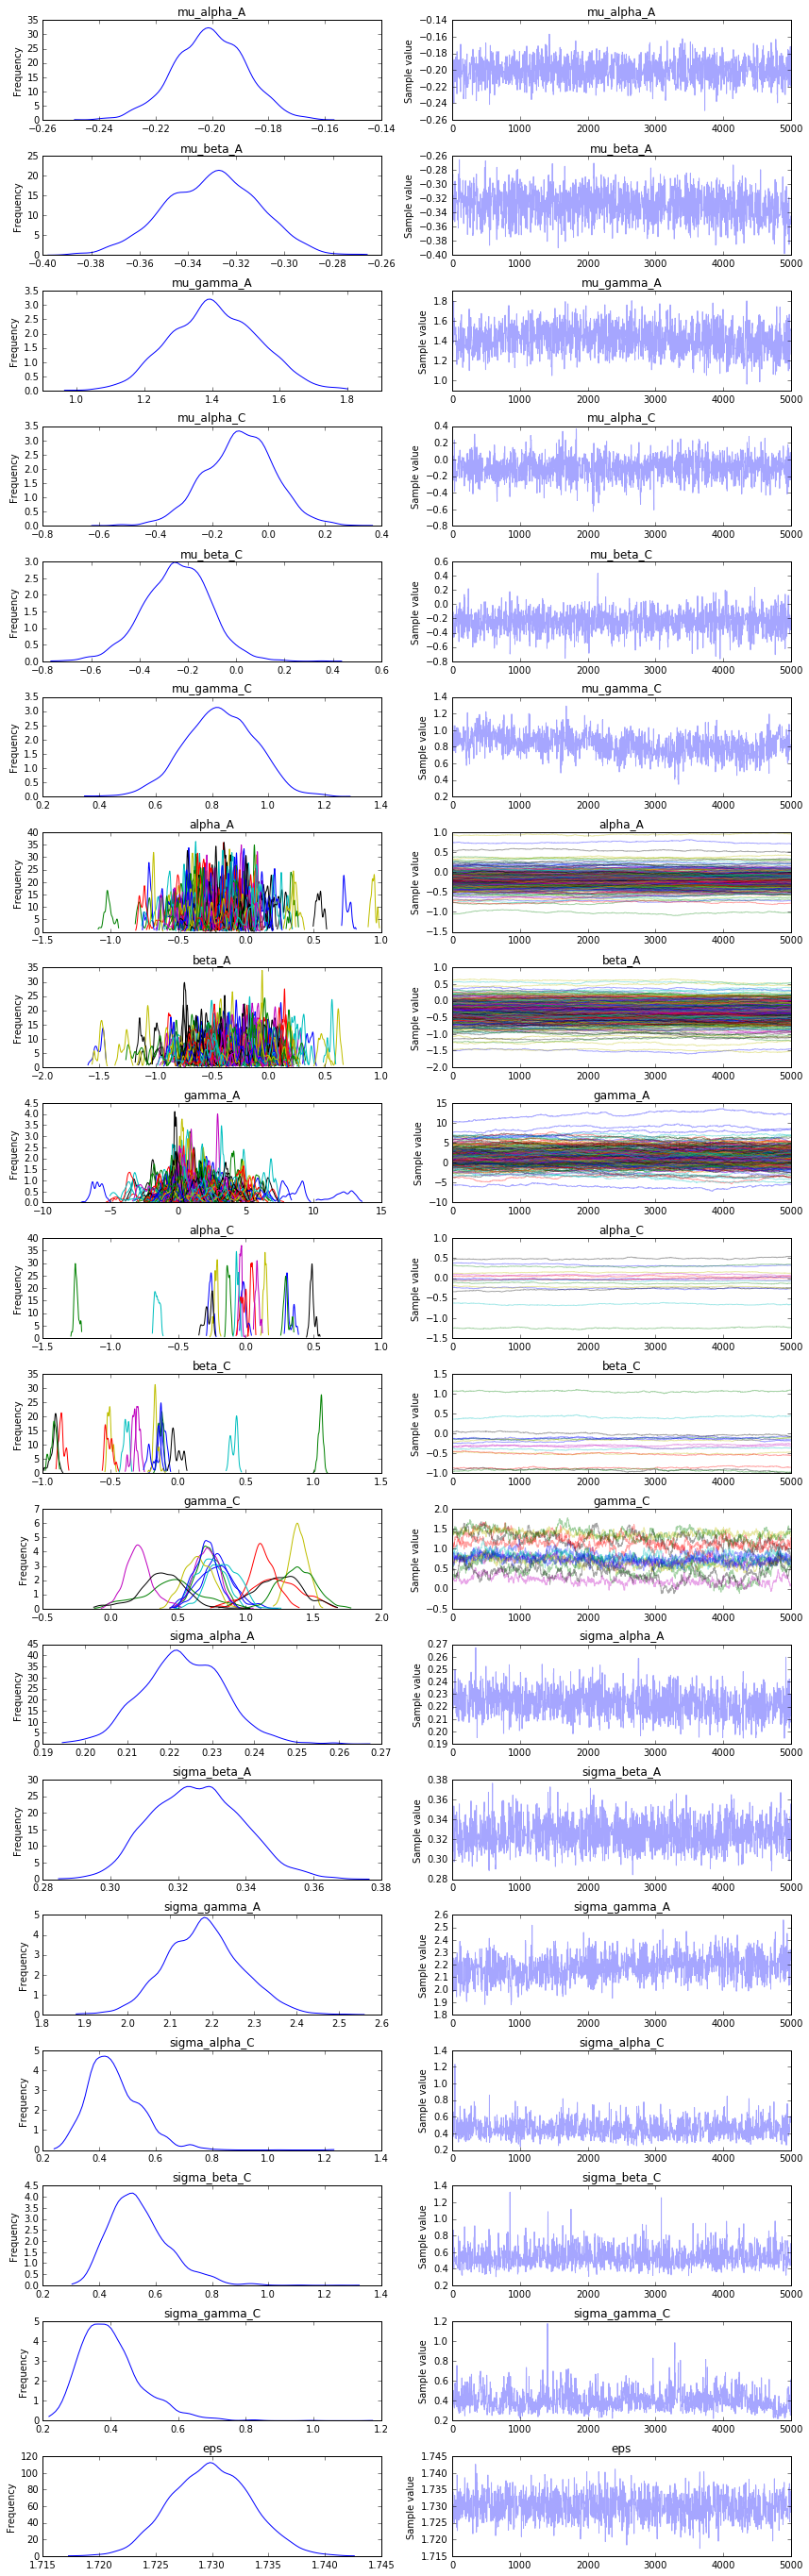

In [54]:
res = pm.traceplot(last_5000_trace)

### Preliminary Conclusions

From the plots above, several conclusions can be drawn:

1. There are three airports with intercepts ($\alpha_A$) significantly larger than the rest.
2. There is three carriers with an intercept ($\alpha_C$) significantly larger than the rest.
3. There is a negative effect of temperature on delay times ($\mu_{\beta_A}, \mu_{\beta_C} \lesssim 0$); decreasing temperature increases delay times.
4. There is a positive effect of temperature on delay times; increasing precipitation increases delay times ($\mu_{\gamma_A}, \mu_{\gamma_C} > 0$)

Converting these measurements into human comprehensible units is problematic because of the non-linear transform used on the target variable. However, the signs of the slopes seem reasonable: cold weather and precipitation both increase delays.

#### 3 Worst Airports (Ignoring Effects of Weather)

Las Vegas, El Paso, and Denver

In [56]:
worst_airports_enc = last_5000_trace[-1]['alpha_A'].argsort()[-3:]
airport_enc.inverse_transform(worst_airports_enc)

array(['ELP', 'DEN', 'LAS'], dtype=object)

#### Worst Carrier (Ignoring Effects of Weather)

Frontier Airlines

In [57]:
worst_carrier_enc = last_5000_trace[-1]['alpha_C'].argmax()
carrier_enc.inverse_transform(worst_carrier_enc)

'F9'

### Future Work on Bayesian Model

1. The posterior could be used to generate retro-dictions *with* credibility intervals; the resulting distribution could be compared to the actual distribution to see if the model is working properly. I had difficulty implementing this with pymc3, though.
1. Along related lines, the inference could be done on the train set, and (independent) predictions could be generated for the train set to evaluate the model.

<a id='conclusions'></a>

# Conclusions and Summary

A conventional ML pipeline is easy to implement using Python (pandas, scikit-learn), but both the performance of the models and its interpretability leave something to be desired. Both the random forest and linear regression models explained only 10-20% of the variance in the test set data, in spite of being trained on nearly 300K observations. In the conventional ML approach, weather seems to be unimportant.

However, these ML models are deficient in how they incorporate categorical variables such as the carrier or the airport. An ideal model would involve learning from the data when it is available, but defaulting to the group mean in cases where it is not. This entails a hierarchical approach, which I pursued using a Bayesian framework (in pymc3). The model neatly incorporates "smart regularization": the model defaults to the mean for the airports or carriers when little data is available for a specific airport or carrier. Weather seems to exert an important influence on the delay times: more precipitation increases delay times, while warmer temperatures reduce delay times, in accordance with intuition. Although much more work needs to be done, I feel that the hierarchical approach should yield better predictions than conventional ML (although I haven't proven this, due to difficulties with pymc3), in addition to being easier to understand and interpret.